<a href="https://colab.research.google.com/github/Woody-Wan/CS-542/blob/main/task2_template_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [ ]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.8.0'

#### Load Image Data

In [ ]:
DATA_LIST = os.listdir('D:/Workspace/CS542/Class Challenge/Covid_Data_GradientCrescent/all')
DATASET_PATH  = 'D:/Workspace/CS542/Class Challenge/Covid_Data_GradientCrescent/all/train'
TEST_DIR =  'D:/Workspace/CS542/Class Challenge/Covid_Data_GradientCrescent/all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 54  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 200
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

C:\Users\woody\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [ ]:
Xception = tf.keras.applications.Xception(input_shape = (224, 224, 3),
                                               include_top=False,
                                               weights='imagenet',
                                               classifier_activation = None)
Xception.trainable = False
flatten_1 = tf.keras.layers.Flatten()
dense_feature_1 = tf.keras.layers.Dense(256, kernel_regularizer='l2')
dense_feature_2 = tf.keras.layers.Dense(128, kernel_regularizer='l2')
Dropout = tf.keras.layers.Dropout(0.5)
dense_1 = tf.keras.layers.Dense(4, activation = 'softmax')


model = tf.keras.Sequential([
  Xception,
  flatten_1,
  dense_feature_1,
  Dropout,
  dense_feature_2,
  Dropout,
  dense_1,
])

model_lowest_loss = model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 46,585,260
Trainable params: 25,723,780
No

#### [5 points] Train Model

In [ ]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="Task2_best_weight_Xception",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

#raise NotImplementedError("Use the model.fit function to train your network")
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits = True),optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE), metrics = ['accuracy'])
history = model.fit(train_batches, epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,validation_data = valid_batches,steps_per_epoch = STEP_SIZE_TRAIN,validation_steps = STEP_SIZE_VALID, callbacks=[model_checkpoint_callback,reduce_lr])

4
1


C:\Users\woody\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\woody\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/200
4/4 [==============================] - 34s 7s/step - loss: 29.9064 - accuracy: 0.3380 - val_loss: 26.8395 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 2/200
4/4 [==============================] - 22s 6s/step - loss: 27.8842 - accuracy: 0.5139 - val_loss: 32.9736 - val_accuracy: 0.4630 - lr: 5.0000e-04
Epoch 3/200
4/4 [==============================] - 22s 6s/step - loss: 26.8964 - accuracy: 0.5602 - val_loss: 22.1390 - val_accuracy: 0.6852 - lr: 5.0000e-04
Epoch 4/200
4/4 [==============================] - 23s 6s/step - loss: 25.5387 - accuracy: 0.5972 - val_loss: 18.9933 - val_accuracy: 0.5926 - lr: 5.0000e-04
Epoch 5/200
4/4 [==============================] - 22s 6s/step - loss: 22.9779 - accuracy: 0.6343 - val_loss: 25.9764 - val_accuracy: 0.6111 - lr: 5.0000e-04
Epoch 6/200
4/4 [==============================] - 21s 5s/step - loss: 24.4122 - accuracy: 0.6204 - val_loss: 20.0355 - val_accuracy: 0.5556 - lr: 5.0000e-04
Epoch 7/200
4/4 [==============================] - 2

4/4 [==============================] - 20s 5s/step - loss: 17.0787 - accuracy: 0.6944 - val_loss: 14.7657 - val_accuracy: 0.7222 - lr: 5.0000e-04
Epoch 53/200
4/4 [==============================] - 22s 5s/step - loss: 15.4968 - accuracy: 0.7500 - val_loss: 14.4741 - val_accuracy: 0.6296 - lr: 5.0000e-04
Epoch 54/200
4/4 [==============================] - 21s 5s/step - loss: 17.2822 - accuracy: 0.6944 - val_loss: 19.3730 - val_accuracy: 0.6296 - lr: 5.0000e-04
Epoch 55/200
4/4 [==============================] - 21s 5s/step - loss: 17.2612 - accuracy: 0.7176 - val_loss: 15.8786 - val_accuracy: 0.6852 - lr: 5.0000e-04
Epoch 56/200
4/4 [==============================] - 21s 5s/step - loss: 17.0893 - accuracy: 0.7130 - val_loss: 13.7481 - val_accuracy: 0.7222 - lr: 5.0000e-04
Epoch 57/200
4/4 [==============================] - 21s 5s/step - loss: 18.9196 - accuracy: 0.6944 - val_loss: 15.4223 - val_accuracy: 0.6481 - lr: 5.0000e-04
Epoch 58/200
4/4 [==============================] - 22s 6s/

4/4 [==============================] - 22s 5s/step - loss: 13.1227 - accuracy: 0.7500 - val_loss: 11.8268 - val_accuracy: 0.7407 - lr: 5.0000e-04
Epoch 104/200
4/4 [==============================] - 21s 5s/step - loss: 14.8189 - accuracy: 0.7269 - val_loss: 12.0061 - val_accuracy: 0.7037 - lr: 5.0000e-04
Epoch 105/200
4/4 [==============================] - 22s 6s/step - loss: 12.7303 - accuracy: 0.7500 - val_loss: 15.6261 - val_accuracy: 0.6481 - lr: 5.0000e-04
Epoch 106/200
4/4 [==============================] - 22s 6s/step - loss: 15.1004 - accuracy: 0.6991 - val_loss: 15.4477 - val_accuracy: 0.6481 - lr: 5.0000e-04
Epoch 107/200
4/4 [==============================] - 21s 6s/step - loss: 12.8788 - accuracy: 0.7407 - val_loss: 12.5312 - val_accuracy: 0.6296 - lr: 5.0000e-04
Epoch 108/200
4/4 [==============================] - 20s 5s/step - loss: 14.3197 - accuracy: 0.7083 - val_loss: 10.7215 - val_accuracy: 0.7407 - lr: 5.0000e-04
Epoch 109/200
4/4 [==============================] - 2

4/4 [==============================] - 17s 4s/step - loss: 11.2459 - accuracy: 0.6944 - val_loss: 9.7129 - val_accuracy: 0.7407 - lr: 5.0000e-04
Epoch 155/200
4/4 [==============================] - 16s 4s/step - loss: 10.5756 - accuracy: 0.7454 - val_loss: 9.4829 - val_accuracy: 0.7407 - lr: 5.0000e-04
Epoch 156/200
4/4 [==============================] - 14s 3s/step - loss: 11.0346 - accuracy: 0.7361 - val_loss: 9.0763 - val_accuracy: 0.6667 - lr: 5.0000e-04
Epoch 157/200
4/4 [==============================] - 12s 3s/step - loss: 10.4923 - accuracy: 0.7269 - val_loss: 9.5565 - val_accuracy: 0.7222 - lr: 5.0000e-04
Epoch 158/200
4/4 [==============================] - 13s 3s/step - loss: 11.3024 - accuracy: 0.7407 - val_loss: 9.6076 - val_accuracy: 0.7037 - lr: 5.0000e-04
Epoch 159/200
4/4 [==============================] - 13s 3s/step - loss: 9.8049 - accuracy: 0.7824 - val_loss: 10.3893 - val_accuracy: 0.7222 - lr: 5.0000e-04
Epoch 160/200
4/4 [==============================] - 13s 3s/

#### [5 points] Plot Accuracy and Loss During Training

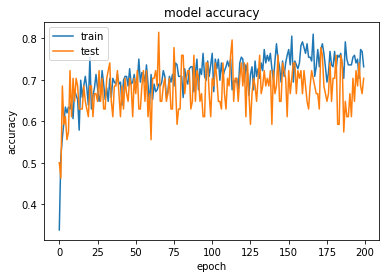

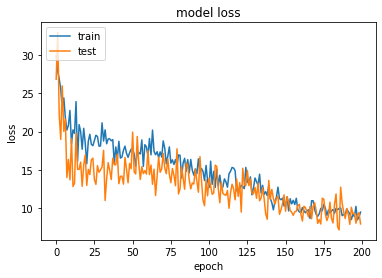

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Testing Model

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36


C:\Users\woody\AppData\Local\Temp\ipykernel_23412\463003407.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),


36/36 [==============================] - 7s 186ms/step - loss: 7.7627 - accuracy: 0.8333
Test loss: 7.7627434730529785
Test accuracy: 0.8333333134651184


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 270 images belonging to 4 classes.


C:\Users\woody\AppData\Local\Temp\ipykernel_23412\429691970.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = intermediate_layer_model.predict_generator(tsne_eval_generator)
C:\Users\woody\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\woody\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


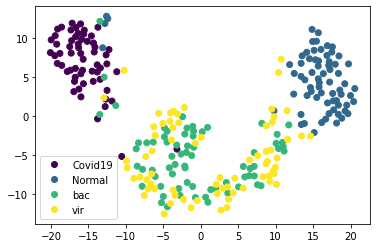

In [ ]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_2').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

tsne_eval_generator.reset()
pred = intermediate_layer_model.predict_generator(tsne_eval_generator)

tsne = TSNE(n_components=2,method='exact')
'''

    * use the generator to get images, pass them to interemediate_layer_model 
    * collect the output features into an array 
    * feed that array into fit_transform 

'''
        


#X_2d = tsne.fit_transform(pred)
tsne_result = tsne.fit_transform(pred)
scatter = plt.scatter(tsne_result[:,0], tsne_result[:,1], c=tsne_eval_generator.labels)
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, ["Covid19","Normal","bac","vir"])




<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->